## Import the Packages

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, Input
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5...
/ [1/1 files][257.5 MiB/257.5 MiB] 100% Done                                    
Operation completed over 1 objects/257.5 MiB.                                    


In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5...
- [1/1 files][ 32.5 MiB/ 32.5 MiB] 100% Done                                    
Operation completed over 1 objects/32.5 MiB.                                     


In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5...
/ [1/1 files][ 31.9 MiB/ 31.9 MiB] 100% Done                                    
Operation completed over 1 objects/31.9 MiB.                                     


In [0]:
def load_dataset():
    train_dataset = h5py.File('sample_data/train.hdf5', "r")
    X_train = np.array(train_dataset["data_x"][:]) # your train set features
    y_train = np.array(train_dataset["data_y"][:]) # your train set labels

    valid_dataset = h5py.File('sample_data/valid.hdf5', "r")
    X_valid = np.array(valid_dataset["data_x"][:]) # your valid set features
    y_valid = np.array(valid_dataset["data_y"][:]) # your valid set labels
    
    test_dataset = h5py.File('sample_data/test.hdf5', "r")
    X_test = np.array(test_dataset["data_x"][:]) # your test set features
    y_test = np.array(test_dataset["data_y"][:]) # your test set labels

    classes = np.array(['01_TUMOR','02_STROMA','03_COMPLEX','04_LYMPHO','05_DEBRIS','06_MUCOSA','07_ADIPOSE','08_EMPTY']) # the list of classes

    return X_train, y_train, X_valid, y_valid, X_test, y_test, classes

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test, classes = load_dataset()

y = 3, it's a '03_COMPLEX' picture.


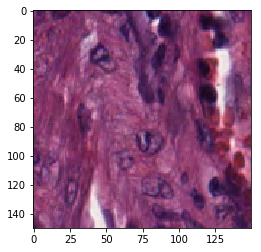

In [0]:
index = 1000
plt.imshow(X_train[index])
print ("y = " + str(y_train[index]) + ", it's a '" + classes[y_train[index-1]] +  "' picture.")


In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000,)
(496, 150, 150, 3)
(496,)
(504, 150, 150, 3)
(504,)


## Data Pre-processing

In [0]:
# Resizing images to 1-D array to be fit into NN
X_train = X_train.reshape(4000, 150, 150, 3)
X_valid = X_valid.reshape(496, 150, 150, 3)
X_test = X_test.reshape(504, 150, 150, 3)

# Converting the data to float type 
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Scaling the data
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

num_classes = 8

# Converting the output to categorical variables
y_train = to_categorical(y_train-1,num_classes)
y_valid = to_categorical(y_valid-1,num_classes)
y_test = to_categorical(y_test-1, num_classes)

In [0]:
# Chacking the train, validation and test sets

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000, 8)
(496, 150, 150, 3)
(496, 8)
(504, 150, 150, 3)
(504, 8)


## Create and Compile the VGG19 Model

In [0]:
# LOAD VGG19
input_tensor = Input(shape=(150,150,3))
model_vgg19_conv = applications.VGG19(weights='imagenet', 
                           include_top=False,
                           input_tensor=input_tensor)
model_vgg19_conv.summary()

W0813 22:06:03.155486 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 22:06:03.194602 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 22:06:03.202436 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 22:06:03.243682 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 3s 0us/step


W0813 22:06:06.648260 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 22:06:06.653332 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Reference link: https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

In [0]:
# Make vgg19 model layers as non trainable
for layer in model_vgg19_conv.layers:
    layer.trainable = False

# Create our own input format
input = Input(shape=(150,150,3),name = 'image_input')   

# Use the generated model 
output_vgg19_conv = model_vgg19_conv(input)

# Add the flatten layer and output layer
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(8, activation='softmax', name='predictions')(x)

# Create our own model
my_model1 = Model(input=input, output=x)
my_model1.summary()
my_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
W0813 22:06:10.425937 140205142775680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               4194816   
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
predictions (Dense)          (None, 8)                 1032      
Total params: 24,285,896
Trainable params: 4,261,512
Non-trainable params: 20,024,384
________________________________________________________

## Model Without Data Augmentation

In [0]:
callbacks1 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
batch_size = 32
nb_classes = 8
nb_epoch = 20

# fit the model
history1 = my_model1.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=nb_epoch,
           callbacks=callbacks1,
           validation_data=(X_valid, y_valid))

Train on 4000 samples, validate on 496 samples
Epoch 1/20
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0361 - acc: 0.9918 - val_loss: 0.4536 - val_acc: 0.8750
Epoch 2/20
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0503 - acc: 0.9835 - val_loss: 0.6002 - val_acc: 0.8407
Epoch 3/20
4000/4000 [==============================] - 14s 4ms/step - loss: 0.1217 - acc: 0.9560 - val_loss: 0.7743 - val_acc: 0.8266
Epoch 4/20
4000/4000 [==============================] - 14s 4ms/step - loss: 0.0904 - acc: 0.9685 - val_loss: 0.5481 - val_acc: 0.8730
Epoch 5/20
4000/4000 [==============================] - 14s 4ms/step - loss: 0.0526 - acc: 0.9822 - val_loss: 0.6558 - val_acc: 0.8448


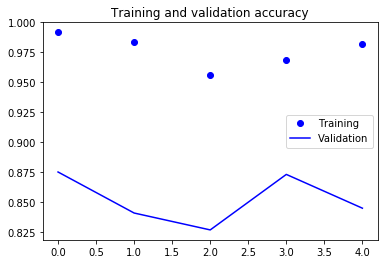

In [0]:
plt.plot(history1.history['acc'], 'bo', label='Training')
plt.plot(history1.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model1 = load_model('best_model1.h5')

In [0]:
score1 = opt_model1.evaluate(X_test,y_test)

504/504 [==============================] - 2s 3ms/step


In [0]:
score1

[0.38810507444265696, 0.8948412698412699]

## Model with Data Augmentation

### Aug1

In [0]:
my_model2 = Model(input=input, output=x)
my_model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen1.fit(X_train)

In [0]:
callbacks2 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history2 = my_model2.fit_generator(datagen1.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks2,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 21s 171ms/step - loss: 0.3703 - acc: 0.8772 - val_loss: 0.4074 - val_acc: 0.8629
Epoch 2/20
125/125 [==============================] - 20s 162ms/step - loss: 0.2961 - acc: 0.8925 - val_loss: 0.4344 - val_acc: 0.8427
Epoch 3/20
125/125 [==============================] - 21s 165ms/step - loss: 0.3178 - acc: 0.8900 - val_loss: 0.3914 - val_acc: 0.8569
Epoch 4/20
125/125 [==============================] - 21s 167ms/step - loss: 0.2577 - acc: 0.9070 - val_loss: 0.3625 - val_acc: 0.8831
Epoch 5/20
125/125 [==============================] - 21s 167ms/step - loss: 0.2536 - acc: 0.9073 - val_loss: 0.3660 - val_acc: 0.8790
Epoch 6/20
125/125 [==============================] - 21s 164ms/step - loss: 0.2587 - acc: 0.9070 - val_loss: 0.4705 - val_acc: 0.8327
Epoch 7/20
125/125 [==============================] - 20s 164ms/step - loss: 0.2603 - acc: 0.9065 - val_loss: 0.3661 - val_acc: 0.8589
Epoch 8/20
125/125 [==============================] - 2

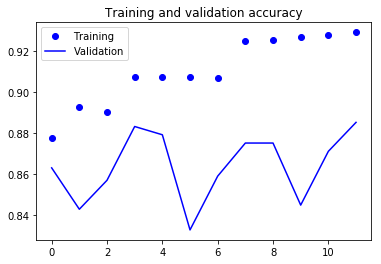

In [0]:
plt.plot(history2.history['acc'], 'bo', label='Training')
plt.plot(history2.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model2 = load_model('best_model2.h5')

In [0]:
score2 = opt_model2.evaluate(X_test,y_test)

504/504 [==============================] - 2s 4ms/step


In [0]:
score2

[0.3052058939541143, 0.9047619047619048]

### Aug2

In [0]:
my_model3 = Model(input=input, output=x)
my_model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen2.fit(X_train)

In [0]:
callbacks3 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history3 = my_model3.fit_generator(datagen2.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks3,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 22s 177ms/step - loss: 0.3488 - acc: 0.8732 - val_loss: 0.3832 - val_acc: 0.8730
Epoch 2/20
125/125 [==============================] - 21s 165ms/step - loss: 0.3255 - acc: 0.8808 - val_loss: 0.4129 - val_acc: 0.8347
Epoch 3/20
125/125 [==============================] - 21s 169ms/step - loss: 0.3413 - acc: 0.8728 - val_loss: 0.3095 - val_acc: 0.8992
Epoch 4/20
125/125 [==============================] - 21s 171ms/step - loss: 0.3122 - acc: 0.8847 - val_loss: 0.3597 - val_acc: 0.8730
Epoch 5/20
125/125 [==============================] - 21s 168ms/step - loss: 0.3126 - acc: 0.8880 - val_loss: 0.3123 - val_acc: 0.8952
Epoch 6/20
125/125 [==============================] - 21s 168ms/step - loss: 0.3132 - acc: 0.8868 - val_loss: 0.3492 - val_acc: 0.8730
Epoch 7/20
125/125 [==============================] - 21s 168ms/step - loss: 0.3092 - acc: 0.8935 - val_loss: 0.3239 - val_acc: 0.8810


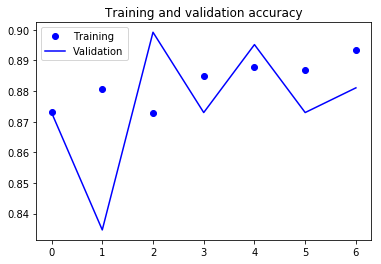

In [0]:
plt.plot(history3.history['acc'], 'bo', label='Training')
plt.plot(history3.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model3 = load_model('best_model3.h5')

In [0]:
score3 = opt_model3.evaluate(X_test,y_test)

504/504 [==============================] - 2s 4ms/step


In [0]:
score3

[0.3062398989707054, 0.8809523809523809]